In [1]:
import collections
import itertools
import json
import pathlib

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker
import ml_collections
import numpy as np
import pandas as pd
import torch

import hier
import hier_torch
import infer
import main
import metrics
import progmet
import tree_util

In [2]:
Trial = collections.namedtuple('Trial', ['root', 'config_file', 'model_file'])

In [97]:
# # Flat softmax with label smoothing.
# PLOT_DIR = 'output/plots/sweep_label_smoothing'
# EXP_DIR = pathlib.Path('/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini')
# EXPERIMENT_PATTERNS = [
#     'flat_softmax-lr-0.01-b-64-wd-0.0003-ep-20',
#     'flat_softmax-ls-*-lr-0.01-b-64-wd-0.0003-ep-20',
# ]
# config_to_hparams = lambda c: (c.train.label_smoothing,)
# predicate = lambda ls: ls < 0.6


# Multilabel focal loss.
PLOT_DIR = 'output/plots/sweep_multilabel_focal'
EXP_DIR = pathlib.Path('/mnt/ssd1/projects/2022-01-hierarchical/experiments')
EXPERIMENT_PATTERNS = [
    '2022-03-31-inat21mini-dgx/multilabel_focal-*-*-lr-0.01-b-64-wd-0.0003-ep-20',
    '2022-03-31-inat21mini/multilabel_focal-0.*-0-lr-0.01-b-64-wd-0.0003-ep-20',
    '2022-03-31-inat21mini/multilabel_focal-none-*-0-lr-0.01-b-64-wd-0.0003-ep-20',
]
config_to_hparams = lambda c: (c.train.focal_gamma, c.train.focal_alpha)
predicate = lambda gamma, alpha: alpha >= 0.4 and gamma > 0


# # Multilabel focal loss, including `loss_weighting`.
# PLOT_DIR = 'output/plots/sweep_multilabel_focal'
# EXP_DIR = pathlib.Path('/mnt/ssd1/projects/2022-01-hierarchical/experiments')
# EXPERIMENT_PATTERNS = [
#     '2022-03-31-inat21mini-dgx/multilabel_focal-*-*-lr-0.01-b-64-wd-0.0003-ep-20',
#     '2022-03-31-inat21mini/multilabel_focal-inv_sqrt-*-*-lr-0.01-b-64-wd-0.0003-ep-20',
# ]
# config_to_hparams = lambda c: (c.train.focal_gamma, c.train.focal_alpha, c.train.loss_weighting)
# predicate = lambda gamma, alpha, loss_weighting: True


# # Bertinetto HXE loss.
# PLOT_DIR = 'output/plots/sweep_hxe'
# EXP_DIR = pathlib.Path('/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini')
# EXPERIMENT_PATTERNS = [
#     'flat_softmax-lr-0.01-b-64-wd-0.0003-ep-20',
#     'flat_bertinetto-*-lr-0.01-b-64-wd-0.0003-ep-20',
# ]
# config_to_hparams = lambda c: (c.train.hxe_alpha,)
# predicate = lambda alpha: True


# # Deep RTC (cut prob).
# PLOT_DIR = 'output/plots/sweep_deep_rtc'
# EXP_DIR = pathlib.Path('/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini')
# EXPERIMENT_PATTERNS = [
#     'share_random_cut-*-lr-0.01-b-64-wd-0.0003-ep-20',
# ]
# config_to_hparams = lambda c: (c.train.random_cut_prob,)
# predicate = lambda alpha: True


# # Margin (scale).
# PLOT_DIR = 'output/plots/sweep_soft_margin'
# EXP_DIR = pathlib.Path('/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-03-31-inat21mini')
# EXPERIMENT_PATTERNS = [
#     'soft_margin-incorrect-*lr-0.01-b-64-wd-0.0003-ep-20',
# ]
# config_to_hparams = lambda c: (c.train.margin_tau,)
# predicate = lambda tau: True

In [98]:
def update_config(config):
    if not hasattr(config.train, 'loss_weighting'):
        setattr(config.train, 'loss_weighting', 'none')
    if not hasattr(config.train, 'margin_tau'):
        setattr(config.train, 'margin_tau', 1.0)
    return config  # For convenience.

In [99]:
experiments = {
    path.name: Trial(
        root=path,
        config_file=path / 'config.json',
        model_file=path / 'checkpoints/epoch-0020.pth')
    for path in sorted(itertools.chain.from_iterable(
        pathlib.Path(EXP_DIR).glob(pattern) for pattern in EXPERIMENT_PATTERNS))
    if (path / 'checkpoints/epoch-0020.pth').exists()
}
list(experiments)

['multilabel_focal-0.5-0-lr-0.01-b-64-wd-0.0003-ep-20',
 'multilabel_focal-0.9-0-lr-0.01-b-64-wd-0.0003-ep-20',
 'multilabel_focal-none-0.95-0-lr-0.01-b-64-wd-0.0003-ep-20',
 'multilabel_focal-0.5-1-lr-0.01-b-64-wd-0.0003-ep-20',
 'multilabel_focal-0.5-2-lr-0.01-b-64-wd-0.0003-ep-20',
 'multilabel_focal-0.8-1-lr-0.01-b-64-wd-0.0003-ep-20',
 'multilabel_focal-0.8-2-lr-0.01-b-64-wd-0.0003-ep-20',
 'multilabel_focal-0.9-1-lr-0.01-b-64-wd-0.0003-ep-20',
 'multilabel_focal-0.9-2-lr-0.01-b-64-wd-0.0003-ep-20',
 'multilabel_focal-0.95-1-lr-0.01-b-64-wd-0.0003-ep-20',
 'multilabel_focal-0.95-2-lr-0.01-b-64-wd-0.0003-ep-20']

In [100]:
# Get params from JSON file not filename (less prone to human error).

configs = {}
for k, experiment in experiments.items():
    with open(experiment.config_file) as f:
        configs[k] = update_config(ml_collections.ConfigDict(json.load(f)))

experiment_hparams = {k: config_to_hparams(c) for k, c in configs.items()}
experiment_hparams

{'multilabel_focal-0.5-0-lr-0.01-b-64-wd-0.0003-ep-20': (2.0, 0.25),
 'multilabel_focal-0.9-0-lr-0.01-b-64-wd-0.0003-ep-20': (2.0, 0.25),
 'multilabel_focal-none-0.95-0-lr-0.01-b-64-wd-0.0003-ep-20': (0.0, 0.95),
 'multilabel_focal-0.5-1-lr-0.01-b-64-wd-0.0003-ep-20': (1.0, 0.5),
 'multilabel_focal-0.5-2-lr-0.01-b-64-wd-0.0003-ep-20': (2.0, 0.5),
 'multilabel_focal-0.8-1-lr-0.01-b-64-wd-0.0003-ep-20': (1.0, 0.8),
 'multilabel_focal-0.8-2-lr-0.01-b-64-wd-0.0003-ep-20': (2.0, 0.8),
 'multilabel_focal-0.9-1-lr-0.01-b-64-wd-0.0003-ep-20': (1.0, 0.9),
 'multilabel_focal-0.9-2-lr-0.01-b-64-wd-0.0003-ep-20': (2.0, 0.9),
 'multilabel_focal-0.95-1-lr-0.01-b-64-wd-0.0003-ep-20': (1.0, 0.95),
 'multilabel_focal-0.95-2-lr-0.01-b-64-wd-0.0003-ep-20': (2.0, 0.95)}

In [101]:
# Filter using predicate.

experiment_hparams = {k: hparams for k, hparams in experiment_hparams.items() if predicate(*hparams)}
experiments = {k: experiments[k] for k in experiment_hparams}
experiment_hparams

{'multilabel_focal-0.5-1-lr-0.01-b-64-wd-0.0003-ep-20': (1.0, 0.5),
 'multilabel_focal-0.5-2-lr-0.01-b-64-wd-0.0003-ep-20': (2.0, 0.5),
 'multilabel_focal-0.8-1-lr-0.01-b-64-wd-0.0003-ep-20': (1.0, 0.8),
 'multilabel_focal-0.8-2-lr-0.01-b-64-wd-0.0003-ep-20': (2.0, 0.8),
 'multilabel_focal-0.9-1-lr-0.01-b-64-wd-0.0003-ep-20': (1.0, 0.9),
 'multilabel_focal-0.9-2-lr-0.01-b-64-wd-0.0003-ep-20': (2.0, 0.9),
 'multilabel_focal-0.95-1-lr-0.01-b-64-wd-0.0003-ep-20': (1.0, 0.95),
 'multilabel_focal-0.95-2-lr-0.01-b-64-wd-0.0003-ep-20': (2.0, 0.95)}

In [102]:
# Arrange by key, ensure unique.

hparams_to_key = dict(sorted((v, k) for k, v in experiment_hparams.items()))
assert len(hparams_to_key) == len(experiment_hparams), 'hparams not unique'

colors = dict(zip(
    hparams_to_key,
    map(matplotlib.cm.get_cmap('tab10'), itertools.count())))

hparams_to_key

{(1.0, 0.5): 'multilabel_focal-0.5-1-lr-0.01-b-64-wd-0.0003-ep-20',
 (1.0, 0.8): 'multilabel_focal-0.8-1-lr-0.01-b-64-wd-0.0003-ep-20',
 (1.0, 0.9): 'multilabel_focal-0.9-1-lr-0.01-b-64-wd-0.0003-ep-20',
 (1.0, 0.95): 'multilabel_focal-0.95-1-lr-0.01-b-64-wd-0.0003-ep-20',
 (2.0, 0.5): 'multilabel_focal-0.5-2-lr-0.01-b-64-wd-0.0003-ep-20',
 (2.0, 0.8): 'multilabel_focal-0.8-2-lr-0.01-b-64-wd-0.0003-ep-20',
 (2.0, 0.9): 'multilabel_focal-0.9-2-lr-0.01-b-64-wd-0.0003-ep-20',
 (2.0, 0.95): 'multilabel_focal-0.95-2-lr-0.01-b-64-wd-0.0003-ep-20'}

In [103]:
device = torch.device('cuda')

In [65]:
import configs.inaturalist2021mini

base_config = configs.inaturalist2021mini.get_config()
base_config.dataset_root = '/home/jack/data/manual/inaturalist2021/'

_, eval_dataset, tree, _, _, eval_label_map = main.make_datasets(base_config)

eval_loader = torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2)

In [66]:
is_leaf = tree.leaf_mask()
specificity = -tree.num_leaf_descendants()
not_trivial = (tree.num_children() != 1)
subtract_children_fn = hier_torch.SubtractChildren(tree)

In [67]:
infer_fns = {
    'leaf': lambda p: infer.argmax_where(p, is_leaf),
    'majority': lambda p: infer.argmax_with_confidence(specificity, p, 0.5, not_trivial),
    # 'exclusive': lambda p: np.argmax(subtract_children_fn(torch.from_numpy(p)).numpy(), axis=-1),
}

markers = {
    'leaf': 'o',
    'majority': '^',
    # 'exclusive': 'd',
}

In [68]:
info_metric = metrics.UniformLeafInfoMetric(tree)
depth_metric = metrics.DepthMetric(tree)

metric_fns = {
    'exact': lambda gt, pr: pr == gt,
    'correct': metrics.IsCorrect(tree),
    'info_excess': info_metric.excess,
    'info_deficient': info_metric.deficient,
    'info_dist': info_metric.dist,
    'info_recall': info_metric.recall,
    'info_precision': info_metric.precision,
    'depth_excess': depth_metric.excess,
    'depth_deficient': depth_metric.deficient,
    'depth_dist': depth_metric.dist,
    'depth_recall': depth_metric.recall,
    'depth_precision': depth_metric.precision,
}

metric_titles = {
    'exact': 'Exact',
    'correct': 'Correct',
    'info_recall': 'Information Recall',
    'info_precision': 'Information Precision',
    'depth_recall': 'Depth Recall',
    'depth_precision': 'Depth Precision',
    'info_lca': 'LCA Information',
    'depth_lca': 'LCA Depth',
}

In [69]:
def apply_model(net, pred_fn, min_threshold, limit=None):
    # Per-example predictions.

    outputs = {
        'gt': [],  # Node in hierarchy.
        'pred': {method: [] for method in infer_fns},
    }
    # Sequence-per-example predictions. Cannot be concatenated due to ragged shape.
    seq_outputs = {
        'pred': [],
        'prob': [],
    }

    net.eval()
    with torch.inference_mode():
        meter = progmet.ProgressMeter('apply', interval_time=5)
        for minibatch in itertools.islice(meter(eval_loader), limit):
            inputs, gt_labels = minibatch
            theta = net(inputs.to(device))
            prob = pred_fn(theta).cpu().numpy()
            pred = {}
            for name, infer_fn in infer_fns.items():
                pred[name] = infer_fn(prob)
            gt_node = eval_label_map.to_node[gt_labels]
            pred_seqs = [
                infer.pareto_optimal_predictions(specificity, p, min_threshold, not_trivial)
                for p in prob
            ]
            prob_seqs = [prob[i, pred_i] for i, pred_i in enumerate(pred_seqs)]
            # Caution: Predictions are *not* truncated.

            outputs['gt'].append(gt_node)
            for method in infer_fns:
                outputs['pred'][method].append(pred[method])
            seq_outputs['pred'].extend(pred_seqs)
            seq_outputs['prob'].extend(prob_seqs)

    # Concatenate results from minibatches.
    leaf_predicate = lambda x: not isinstance(x, dict)  # Treat lists as values, not containers.
    outputs = tree_util.tree_map(np.concatenate, outputs, is_leaf=leaf_predicate)

    return outputs, seq_outputs

In [70]:
def assess_predictions(outputs, seq_outputs):
    gt = outputs['gt']
    pred = outputs['pred']
    pred_seq = seq_outputs['pred']
    prob_seq = seq_outputs['prob']

    # Evaluate predictions for each method.
    pred = {
        method: hier.truncate_at_lca(tree, gt, pr)
        for method, pr in pred.items()
    }
    pred_metrics = {
        method: {field: np.mean(metric_fn(gt, pr))
                 for field, metric_fn in metric_fns.items()}
        for method, pr in pred.items()
    }

    # Evaluate predictions in Pareto sequence.
    find_lca = hier.FindLCA(tree)
    specificity_seq = [specificity[pr_i] for pr_i in pred_seq]
    pred_seq = [hier.truncate_given_lca(gt_i, pr_i, find_lca(gt_i, pr_i)) for gt_i, pr_i in zip(gt, pred_seq)]
    metric_values_seq = {
        field: [metric_fn(gt_i, pr_i) for gt_i, pr_i in zip(gt, pred_seq)]
        for field, metric_fn in metric_fns.items()
    }
    pareto_scores, pareto_totals = metrics.operating_curve(prob_seq, metric_values_seq)
    pareto_means = {k: v / len(gt) for k, v in pareto_totals.items()}

    return pred_metrics, pareto_scores, pareto_means

In [71]:
def resample_threshold(scores, metric, x):
    return metric[np.searchsorted(-scores, -x)]

In [72]:
# Initialize results if not defined.
try:
    results
except NameError:
    results = {}  # Not defined.

In [73]:
MIN_THRESHOLD = None  # Values less than 0.5 may increase runtime significantly.
LIMIT = None

score_grid = np.flip(np.linspace(0, 1, 10001))

for name, experiment in experiments.items():
    if name in results:
        print('cached:', name)
        continue

    # Load model.
    with open(experiment.config_file, 'r') as f:
        config = update_config(ml_collections.ConfigDict(json.load(f)))
    num_outputs = main.get_num_outputs(config.predict, tree)
    net = main.make_model(config.model, num_outputs)
    missing_keys, unexpected_keys = net.load_state_dict(torch.load(experiment.model_file), strict=True)
    assert not missing_keys
    assert not unexpected_keys

    net.to(device)
    _, pred_fn = main.make_loss(config, tree, device)
    outputs, seq_outputs = apply_model(net, pred_fn, min_threshold=MIN_THRESHOLD, limit=LIMIT)
    pred_metrics, pareto_scores, pareto_metrics = assess_predictions(outputs, seq_outputs)
    trial_results = {
        'pred_metrics': pred_metrics,
        'pareto_scores': pareto_scores,
        'pareto_metrics': pareto_metrics,
    }

    # Re-sample the Pareto front; also keeps the memory footprint down.
    trial_results.update({
        'pareto_scores': score_grid[1:],
        'pareto_metrics': {
            field: resample_threshold(
                trial_results['pareto_scores'],
                trial_results['pareto_metrics'][field],
                score_grid)
            for field in trial_results['pareto_metrics']
        },
    })
    results[name] = trial_results

apply:   1% (4/391); T=1.28 f=0.783; mean T=1.28 f=0.783; elapsed 0:00:05; remaining 0:08:14 of 0:08:19
apply:   3% (12/391); T=0.648 f=1.54; mean T=0.858 f=1.17; elapsed 0:00:10; remaining 0:05:25 of 0:05:35
apply:   5% (20/391); T=0.635 f=1.57; mean T=0.769 f=1.30; elapsed 0:00:15; remaining 0:04:45 of 0:05:01
apply:   7% (28/391); T=0.647 f=1.55; mean T=0.734 f=1.36; elapsed 0:00:21; remaining 0:04:26 of 0:04:47
apply:   9% (36/391); T=0.633 f=1.58; mean T=0.711 f=1.41; elapsed 0:00:26; remaining 0:04:13 of 0:04:38
apply:  11% (44/391); T=0.636 f=1.57; mean T=0.698 f=1.43; elapsed 0:00:31; remaining 0:04:02 of 0:04:33
apply:  13% (52/391); T=0.640 f=1.56; mean T=0.689 f=1.45; elapsed 0:00:36; remaining 0:03:53 of 0:04:29
apply:  15% (60/391); T=0.642 f=1.56; mean T=0.683 f=1.47; elapsed 0:00:41; remaining 0:03:46 of 0:04:27
apply:  17% (68/391); T=0.646 f=1.55; mean T=0.678 f=1.47; elapsed 0:00:46; remaining 0:03:39 of 0:04:25
apply:  19% (76/391); T=0.642 f=1.56; mean T=0.674 f=1.4

apply:  59% (229/391); T=0.652 f=1.53; mean T=0.655 f=1.53; elapsed 0:02:30; remaining 0:01:46 of 0:04:16
apply:  61% (237/391); T=0.632 f=1.58; mean T=0.655 f=1.53; elapsed 0:02:35; remaining 0:01:41 of 0:04:16
apply:  63% (245/391); T=0.649 f=1.54; mean T=0.654 f=1.53; elapsed 0:02:40; remaining 0:01:36 of 0:04:16
apply:  65% (253/391); T=0.646 f=1.55; mean T=0.654 f=1.53; elapsed 0:02:45; remaining 0:01:30 of 0:04:16
apply:  67% (261/391); T=0.663 f=1.51; mean T=0.654 f=1.53; elapsed 0:02:51; remaining 0:01:25 of 0:04:16
apply:  69% (269/391); T=0.666 f=1.50; mean T=0.655 f=1.53; elapsed 0:02:56; remaining 0:01:20 of 0:04:16
apply:  71% (277/391); T=0.660 f=1.52; mean T=0.655 f=1.53; elapsed 0:03:01; remaining 0:01:15 of 0:04:16
apply:  73% (285/391); T=0.656 f=1.52; mean T=0.655 f=1.53; elapsed 0:03:07; remaining 0:01:09 of 0:04:16
apply:  75% (293/391); T=0.656 f=1.52; mean T=0.655 f=1.53; elapsed 0:03:12; remaining 0:01:04 of 0:04:16
apply:  77% (301/391); T=0.648 f=1.54; mean T=

apply:  17% (68/391); T=0.667 f=1.50; mean T=0.697 f=1.44; elapsed 0:00:47; remaining 0:03:45 of 0:04:32
apply:  19% (76/391); T=0.665 f=1.50; mean T=0.694 f=1.44; elapsed 0:00:53; remaining 0:03:38 of 0:04:31
apply:  21% (84/391); T=0.669 f=1.49; mean T=0.691 f=1.45; elapsed 0:00:58; remaining 0:03:32 of 0:04:30
apply:  24% (92/391); T=0.651 f=1.54; mean T=0.688 f=1.45; elapsed 0:01:03; remaining 0:03:26 of 0:04:29
apply:  26% (100/391); T=0.661 f=1.51; mean T=0.686 f=1.46; elapsed 0:01:09; remaining 0:03:19 of 0:04:28
apply:  28% (108/391); T=0.666 f=1.50; mean T=0.684 f=1.46; elapsed 0:01:14; remaining 0:03:14 of 0:04:27
apply:  30% (116/391); T=0.654 f=1.53; mean T=0.682 f=1.47; elapsed 0:01:19; remaining 0:03:08 of 0:04:27
apply:  32% (124/391); T=0.658 f=1.52; mean T=0.680 f=1.47; elapsed 0:01:24; remaining 0:03:02 of 0:04:26
apply:  34% (132/391); T=0.655 f=1.53; mean T=0.679 f=1.47; elapsed 0:01:30; remaining 0:02:56 of 0:04:25
apply:  36% (140/391); T=0.656 f=1.52; mean T=0.67

apply:  83% (324/391); T=0.668 f=1.50; mean T=0.634 f=1.58; elapsed 0:03:25; remaining 0:00:42 of 0:04:08
apply:  85% (333/391); T=0.623 f=1.60; mean T=0.633 f=1.58; elapsed 0:03:31; remaining 0:00:37 of 0:04:08
apply:  87% (341/391); T=0.698 f=1.43; mean T=0.635 f=1.58; elapsed 0:03:36; remaining 0:00:32 of 0:04:08
apply:  89% (348/391); T=0.726 f=1.38; mean T=0.637 f=1.57; elapsed 0:03:42; remaining 0:00:27 of 0:04:09
apply:  91% (356/391); T=0.631 f=1.58; mean T=0.637 f=1.57; elapsed 0:03:47; remaining 0:00:22 of 0:04:09
apply:  93% (365/391); T=0.627 f=1.59; mean T=0.636 f=1.57; elapsed 0:03:52; remaining 0:00:17 of 0:04:09
apply:  96% (374/391); T=0.622 f=1.61; mean T=0.636 f=1.57; elapsed 0:03:58; remaining 0:00:11 of 0:04:09
apply:  98% (383/391); T=0.601 f=1.66; mean T=0.635 f=1.57; elapsed 0:04:03; remaining 0:00:05 of 0:04:08
apply: 100% (391/391); T=0.575 f=1.74; mean T=0.634 f=1.58; elapsed 0:04:08
apply:   1% (5/391); T=1.10 f=0.905; mean T=1.10 f=0.905; elapsed 0:00:06; r

apply:  53% (208/391); T=0.644 f=1.55; mean T=0.633 f=1.58; elapsed 0:02:12; remaining 0:01:56 of 0:04:08
apply:  55% (216/391); T=0.632 f=1.58; mean T=0.633 f=1.58; elapsed 0:02:17; remaining 0:01:51 of 0:04:08
apply:  57% (224/391); T=0.630 f=1.59; mean T=0.633 f=1.58; elapsed 0:02:22; remaining 0:01:46 of 0:04:07
apply:  59% (232/391); T=0.669 f=1.49; mean T=0.634 f=1.58; elapsed 0:02:27; remaining 0:01:41 of 0:04:08
apply:  61% (239/391); T=0.743 f=1.35; mean T=0.637 f=1.57; elapsed 0:02:32; remaining 0:01:37 of 0:04:09
apply:  63% (246/391); T=0.760 f=1.32; mean T=0.641 f=1.56; elapsed 0:02:38; remaining 0:01:33 of 0:04:11
apply:  65% (254/391); T=0.695 f=1.44; mean T=0.643 f=1.56; elapsed 0:02:43; remaining 0:01:28 of 0:04:11
apply:  67% (262/391); T=0.685 f=1.46; mean T=0.644 f=1.55; elapsed 0:02:49; remaining 0:01:23 of 0:04:12
apply:  69% (270/391); T=0.697 f=1.44; mean T=0.645 f=1.55; elapsed 0:02:54; remaining 0:01:18 of 0:04:12
apply:  71% (278/391); T=0.680 f=1.47; mean T=

apply:  16% (62/391); T=0.629 f=1.59; mean T=0.667 f=1.50; elapsed 0:00:41; remaining 0:03:40 of 0:04:21
apply:  18% (71/391); T=0.619 f=1.61; mean T=0.661 f=1.51; elapsed 0:00:47; remaining 0:03:32 of 0:04:19
apply:  20% (79/391); T=0.635 f=1.57; mean T=0.659 f=1.52; elapsed 0:00:52; remaining 0:03:25 of 0:04:18
apply:  22% (87/391); T=0.642 f=1.56; mean T=0.657 f=1.52; elapsed 0:00:57; remaining 0:03:20 of 0:04:17
apply:  24% (95/391); T=0.634 f=1.58; mean T=0.655 f=1.53; elapsed 0:01:02; remaining 0:03:14 of 0:04:16
apply:  26% (103/391); T=0.647 f=1.55; mean T=0.654 f=1.53; elapsed 0:01:07; remaining 0:03:08 of 0:04:16
apply:  28% (111/391); T=0.629 f=1.59; mean T=0.653 f=1.53; elapsed 0:01:12; remaining 0:03:03 of 0:04:15
apply:  30% (119/391); T=0.646 f=1.55; mean T=0.652 f=1.53; elapsed 0:01:18; remaining 0:02:57 of 0:04:15
apply:  32% (127/391); T=0.635 f=1.58; mean T=0.651 f=1.54; elapsed 0:01:23; remaining 0:02:52 of 0:04:15
apply:  35% (135/391); T=0.632 f=1.58; mean T=0.650

In [85]:
INTEGRALS = {
    'AC(depth)': ('depth_recall', 'correct'),
    'AC(info)': ('info_recall', 'correct'),
    'AP(depth)': ('depth_recall', 'depth_precision'),
    'AP(info)': ('info_recall', 'info_precision'),
    'AC(exact)': ('exact', 'correct'),
}

auc = {
    integral_key: {
        name: metrics.pareto_integrate(
            results[name]['pareto_metrics'][x],
            results[name]['pareto_metrics'][y])
        for name in experiments if name in results
    } for integral_key, (x, y) in INTEGRALS.items()
}

auc = pd.DataFrame(auc)
auc = auc.set_index(auc.index.map(experiment_hparams)).sort_index()
auc.style.format('{:.1%}'.format)

In [86]:
auc.sort_values('AP(info)', ascending=False).style.format('{:.1%}'.format)

In [75]:
INTERCEPTS = [
    'depth_recall',
    'info_recall',
    'exact',
]

CORRECT = [95, 90]

recalls = {
    (c, y): {
        name: metrics.pareto_intercept(
            results[name]['pareto_metrics']['correct'],
            results[name]['pareto_metrics'][y],
            c / 100)
        for name in results
    } for c in CORRECT for y in INTERCEPTS
}

recalls = pd.DataFrame(recalls)
recalls = recalls.set_index(recalls.index.map(experiment_hparams)).sort_index()
recalls.style.format('{:.1%}'.format)

In [87]:
recalls.sort_values((90, 'info_recall'), ascending=False).style.format('{:.1%}'.format)

In [104]:
def plot_metrics(x, y, tickres=None, is_pr=True, save=False):
    plt.figure(figsize=(5, 4))
    for hparams, name in hparams_to_key.items():
        pred_metrics = results[name]['pred_metrics']
        pareto_scores = results[name]['pareto_scores']
        pareto_metrics = results[name]['pareto_metrics']
        ge = np.concatenate(([True], pareto_scores >= 0.5))
        le = np.concatenate(([False], pareto_scores <= 0.5))
        plt.plot(pareto_metrics[x][ge], pareto_metrics[y][ge],
                 color=colors[hparams], label=', '.join(map(str, hparams)))
        plt.plot(pareto_metrics[x][le], pareto_metrics[y][le],
                 color=colors[hparams], linestyle='--')
        for method in ['leaf', 'majority']:  # pred_metrics.items():
            plt.plot(pred_metrics[method][x], pred_metrics[method][y],
                     color=colors[hparams], marker=markers[method],
                     markerfacecolor='none')

    ax = plt.gca()
    if is_pr:
        plt.xlim(left=0)
        plt.ylim(top=1)
        # plt.ylim(np.clip(plt.ylim(), 0, 1))
        # plt.xlim(np.clip(plt.xlim(), 0, 1))
    if tickres:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tickres))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(tickres))
    # plt.axis('equal')
    # plt.gca().set_aspect(1)
    plt.grid()
    plt.xlabel(metric_titles.get(x, x))
    plt.ylabel(metric_titles.get(y, y))
    plt.legend()

    if save:
        pathlib.Path(PLOT_DIR).mkdir(parents=True, exist_ok=True)
        plt.savefig(pathlib.Path(PLOT_DIR) / f'{x}-{y}.pdf')

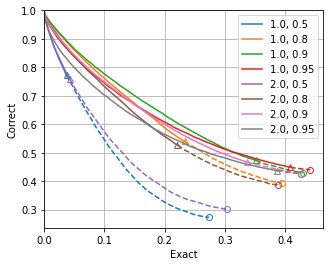

In [105]:
plot_metrics('exact', 'correct', save=True)

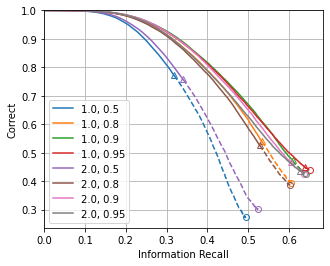

In [106]:
plot_metrics('info_recall', 'correct', save=True)

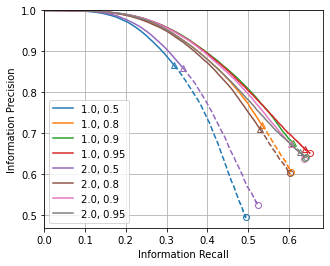

In [107]:
plot_metrics('info_recall', 'info_precision', save=True)

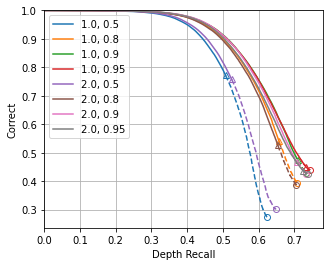

In [108]:
plot_metrics('depth_recall', 'correct', save=True)

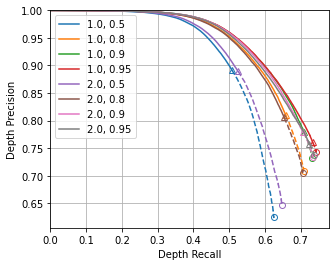

In [109]:
plot_metrics('depth_recall', 'depth_precision', save=True)